In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import featuretools as ft

import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        pass

/kaggle/input/danthon2021/data_train.csv
/kaggle/input/danthon2021/sample_submission.csv
/kaggle/input/danthon2021/data_test.csv
/kaggle/input/danthon2021/irregularities.csv
/kaggle/input/danthon2021/alerts.csv


# Read Train Data

In [3]:
all_train_data = pd.read_csv('/kaggle/input/danthon2021/data_train.csv')
all_train_data

,Ids,Labels
0,2e69e9384_2020-10-06_13,True
1,2e6992c7c_2020-10-02_17,True
2,2e69ef474_2020-09-13_19,True
3,2e69c5fd4_2020-10-10_15,True
4,2e6992134_2020-09-12_11,True
...,...,...
71331,2e69eea5c_2020-11-09_10,False
71332,2e69c5944_2020-10-27_12,True
71333,2e69f2cd4_2020-11-07_14,True
71334,2e68e64e4_2020-09-23_9,False


In [4]:
all_test_data = pd.read_csv('/kaggle/input/danthon2021/data_test.csv')
all_test_data

,Ids
0,2e6992a84_2020-11-25_18
1,2e68e62f4_2020-11-29_20
2,2e68e81a4_2020-11-27_10
3,2e69eec04_2020-11-24_7
4,2e698e4a4_2020-11-27_8
...,...
13836,2e68dd414_2020-11-26_5
13837,2e698541c_2020-11-24_22
13838,2e69e8e0c_2020-11-24_10
13839,2e699a1cc_2020-11-24_18


# Features Encoder

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
all_train_data['Labels']=encoder.fit_transform(all_train_data['Labels'])

In [6]:
all_train_data[['s2token_15','pub_date','hour']] = all_train_data['Ids'].str.split('_',expand=True)

In [7]:
all_test_data[['s2token_15','pub_date','hour']] = all_test_data['Ids'].str.split('_',expand=True)

In [8]:
all_train_data

,Ids,Labels,s2token_15,pub_date,hour
0,2e69e9384_2020-10-06_13,1,2e69e9384,2020-10-06,13
1,2e6992c7c_2020-10-02_17,1,2e6992c7c,2020-10-02,17
2,2e69ef474_2020-09-13_19,1,2e69ef474,2020-09-13,19
3,2e69c5fd4_2020-10-10_15,1,2e69c5fd4,2020-10-10,15
4,2e6992134_2020-09-12_11,1,2e6992134,2020-09-12,11
...,...,...,...,...,...
71331,2e69eea5c_2020-11-09_10,0,2e69eea5c,2020-11-09,10
71332,2e69c5944_2020-10-27_12,1,2e69c5944,2020-10-27,12
71333,2e69f2cd4_2020-11-07_14,1,2e69f2cd4,2020-11-07,14
71334,2e68e64e4_2020-09-23_9,0,2e68e64e4,2020-09-23,9


In [9]:
all_test_data

,Ids,s2token_15,pub_date,hour
0,2e6992a84_2020-11-25_18,2e6992a84,2020-11-25,18
1,2e68e62f4_2020-11-29_20,2e68e62f4,2020-11-29,20
2,2e68e81a4_2020-11-27_10,2e68e81a4,2020-11-27,10
3,2e69eec04_2020-11-24_7,2e69eec04,2020-11-24,7
4,2e698e4a4_2020-11-27_8,2e698e4a4,2020-11-27,8
...,...,...,...,...
13836,2e68dd414_2020-11-26_5,2e68dd414,2020-11-26,5
13837,2e698541c_2020-11-24_22,2e698541c,2020-11-24,22
13838,2e69e8e0c_2020-11-24_10,2e69e8e0c,2020-11-24,10
13839,2e699a1cc_2020-11-24_18,2e699a1cc,2020-11-24,18


In [10]:
all_train_data['pub_date'] = pd.to_datetime(all_train_data['pub_date'], errors='coerce')
all_train_data['day'] = all_train_data['pub_date'].dt.day_name() 

In [11]:
all_test_data['pub_date'] = pd.to_datetime(all_test_data['pub_date'], errors='coerce')
all_test_data['day'] = all_test_data['pub_date'].dt.day_name() 

In [12]:
!pip install s2cell
import s2cell
all_train_data['latitude']=all_train_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[0])
all_train_data['longitude']=all_train_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[1])

all_test_data['latitude']=all_test_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[0])
all_test_data['longitude']=all_test_data['s2token_15'].apply (lambda row: s2cell.token_to_lat_lon(row)[1])


In [13]:
all_train_data['Labels']=pd.to_numeric(all_train_data['Labels'])
all_train_data['hour']=pd.to_numeric(all_train_data['hour'])
all_test_data['hour']=pd.to_numeric(all_test_data['hour'])


In [14]:
y_train = all_train_data['Labels']

In [15]:
all_train_data['day']=encoder.fit_transform(all_train_data['day'])

In [16]:
all_test_data['day']=encoder.fit_transform(all_test_data['day'])

In [17]:
dropped_columns = ['Labels','Ids','pub_date','s2token_15']
for col in dropped_columns:
    all_train_data = all_train_data.drop(col,axis=1)

In [18]:
dropped_columns_test = ['Ids','pub_date','s2token_15']

for col in dropped_columns_test:
    all_test_data = all_test_data.drop(col,axis=1)

In [19]:
all_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71336 entries, 0 to 71335
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       71336 non-null  int64  
 1   day        71336 non-null  int64  
 2   latitude   71336 non-null  float64
 3   longitude  71336 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 2.2 MB


In [20]:
all_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13841 entries, 0 to 13840
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       13841 non-null  int64  
 1   day        13841 non-null  int64  
 2   latitude   13841 non-null  float64
 3   longitude  13841 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 432.7 KB


In [21]:
y_train.value_counts()

1    47183
0    24153
Name: Labels, dtype: int64

# CatBoost

In [22]:
from sklearn.feature_selection import VarianceThreshold
X = all_train_data
selector = VarianceThreshold()
print("Original feature shape:", X.shape)
new_X = selector.fit_transform(X)
print("Transformed feature shape:", new_X.shape)

#The output shows that 
#the transformed features are the same shape so all features have at least some variance.

Original feature shape: (71336, 4)
Transformed feature shape: (71336, 4)


In [23]:

from catboost import Pool, CatBoostClassifier, cv

In [24]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(all_train_data,y_train, test_size=0.2, random_state=38)


In [25]:
model = CatBoostClassifier(iterations=10000,learning_rate=0.01, l2_leaf_reg=3.5,
                           colsample_bylevel=    0.0962895297660657,depth= 11, boosting_type='Plain',  
                           eval_metric="CrossEntropy",use_best_model=True
                           ,random_seed=22,bootstrap_type= "Bernoulli",subsample=0.6927844340277456)

In [26]:
cate_features_index = np.where(X_train_.dtypes != float)[0] 


In [27]:
model.fit(X_train_, y_train_, cat_features=cate_features_index,eval_set=(X_test_, y_test_))


0:	learn: 0.6920003	test: 0.6919710	best: 0.6919710 (0)	total: 69.3ms	remaining: 11m 33s
1:	learn: 0.6909616	test: 0.6908965	best: 0.6908965 (1)	total: 84.8ms	remaining: 7m 3s
2:	learn: 0.6899439	test: 0.6898435	best: 0.6898435 (2)	total: 101ms	remaining: 5m 36s
3:	learn: 0.6889022	test: 0.6887764	best: 0.6887764 (3)	total: 125ms	remaining: 5m 13s
4:	learn: 0.6878161	test: 0.6876828	best: 0.6876828 (4)	total: 147ms	remaining: 4m 54s
5:	learn: 0.6868594	test: 0.6866917	best: 0.6866917 (5)	total: 162ms	remaining: 4m 29s
6:	learn: 0.6859221	test: 0.6857203	best: 0.6857203 (6)	total: 177ms	remaining: 4m 12s
7:	learn: 0.6850038	test: 0.6847683	best: 0.6847683 (7)	total: 192ms	remaining: 3m 59s
8:	learn: 0.6841041	test: 0.6838352	best: 0.6838352 (8)	total: 208ms	remaining: 3m 51s
9:	learn: 0.6832227	test: 0.6829207	best: 0.6829207 (9)	total: 225ms	remaining: 3m 44s
10:	learn: 0.6823591	test: 0.6820245	best: 0.6820245 (10)	total: 240ms	remaining: 3m 37s
11:	learn: 0.6814485	test: 0.6810962	be

In [28]:
pred = model.predict_proba(all_test_data)
preds= pred[:,1]

In [29]:
preds

array([0.68755841, 0.4830197 , 0.60728138, ..., 0.68053251, 0.63296367,
       0.64892778])

In [30]:
preds=["TRUE" if x>0.60 else 'FALSE' for x in preds]


In [31]:
preds

['TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'FALSE',
 'TRUE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE

In [32]:
submission = pd.read_csv('/kaggle/input/danthon2021/data_test.csv')
submission['Labels']=preds
print("submission")
submission.to_csv('test-catboost-scv.csv',index=False)

submission


# Hyper Param

In [33]:
import optuna

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [34]:
X = all_train_data.iloc[:,:].to_numpy()
# X = all_train_data
y = y_train.copy()
def objective(trial):
#     train_x, valid_x, train_y, valid_y = train_test_split(all_train_data,y_train, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = CatBoostClassifier(**param)

#     gbm.fit(train_x, train_y, cat_features=cate_features_index, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#     preds = gbm.predict(valid_x)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
    '''cross-validation'''
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X,y):
        X_train, X_valid = X[train_index], X[test_index]
        X_train = pd.DataFrame(X_train)
        X_train[[0,1]]=X_train[[0,1]].astype('int') 
        X_valid = pd.DataFrame(X_valid)
        X_valid[[0,1]]=X_valid[[0,1]].astype('int') 
        y_train, y_valid = y[train_index], y[test_index]
        clf = CatBoostClassifier(**param)
        clf.fit(X_train, y_train, cat_features=[0,1],eval_set=[(X_valid, y_valid)], verbose=0)
        y_pred_test = clf.predict(X_valid)
        y_pred_test=y_pred_test.round(0).astype(int)
        score = f1_score(y_pred_test,y_valid)
        CV_score_array.append(score)
    avg = np.mean(CV_score_array)
#     return accuracy
    return avg

In [35]:

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, timeout=600)

In [36]:

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

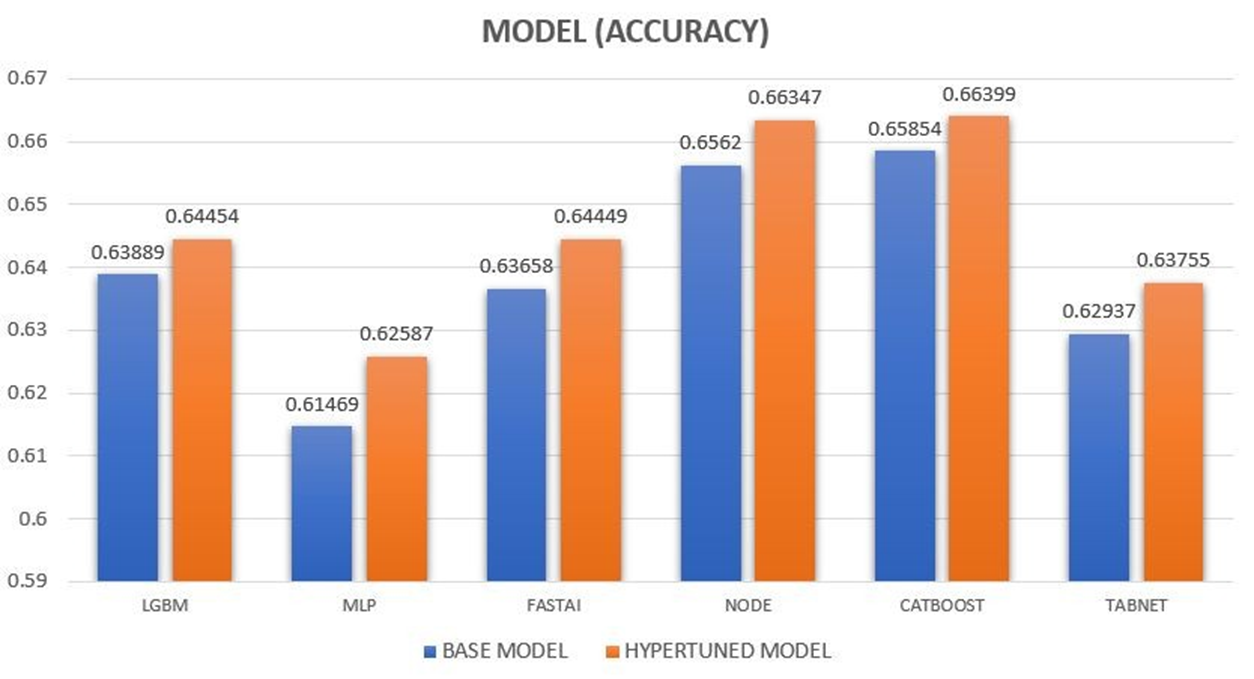

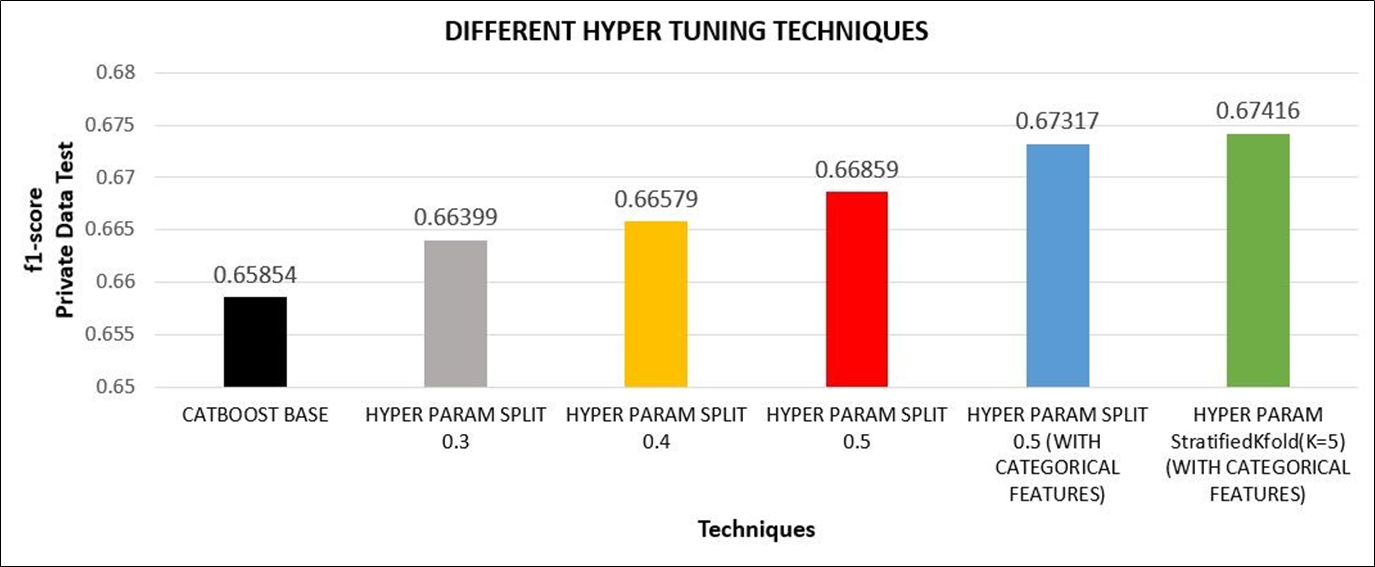


# Conclusions

1. CATBOOST has the highest accuracy  among all the models.
2. CATBOOST has beneﬁt on the robustness of using categorical data  features.
3. Only using 4 features, our technique/model is able to achieved  a fast yet high and comparable  accuracy on leaderboard.
4. Not much features could be used rawly. To get higher accuracy In the  future, Well feature engineering is  required to apply on dataset.
